In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import csv
sck = pd.read_csv('SCK/Oct14.csv')
#air = pd.read_table('AirIQ/Nov2.TXT')
fs = pd.read_csv('FallKit_fixedsite/Oct14_5s.csv',skiprows=[0,2,3])
gps = pd.read_csv('GPS rides/Oct14/Oct14.csv',skiprows=19)

## PART 1) 
### reading in

In [2]:
# functions for conversions
get_datetime = lambda s: datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
get_datetime1 = lambda s: datetime.datetime.strptime(s, "%m/%d/%y %H:%M")
from_datetime = lambda s: datetime.datetime.strftime(s, '%Y-%m-%d %H:%M:%S')

In [3]:
# correcting the sck and fs times (adding on the seconds) and making it an array
def convert_time(var):
    string = []
    stime = []
    for i in range(0,len(var)):
        string = str(var[i])
        sck_dt = get_datetime1(string)
        stime = np.append(sck_dt,stime)

    # adding in the 5s intervals into the sck data and converting to appropriate format
    de = []
    for i in range(len(stime)):
        stime[i] = stime[i-1] + datetime.timedelta(seconds=5)
        xs = from_datetime(stime[i])
        de = np.append(xs,de)
    sck_5s = de
    sck_5s = sck_5s[::-1]
    return sck_5s

In [4]:
fs_time = fs['TIMESTAMP'][:]
sck_time = sck[' UTC']
xf = convert_time(fs_time)
xs = convert_time(sck_time)

In [5]:
# taking out the garbage (T and Z) from the gps times
gps_ntime = []
for i in range(541): # this range gets us ride of the NaNs at the bottom
    noT = gps['Time'][i].replace('T',' ')
    noZ = noT.replace('Z','')
    gps_ntime = np.append(noZ,gps_ntime)
    
gtime = gps_ntime[::-1] # reversed

In [6]:
# shifting the GPS times
# changing arrays to and from datetimes so we can make a time change

gtime_adj = []
for i in range(len(gtime)):
    gobe = datetime.datetime.strptime(gtime[i],'%Y-%m-%d %H:%M:%S')
    gtime_adj = np.append(gobe,gtime_adj)
gnew = gtime_adj + datetime.timedelta(hours=-5) # shift hours
xg = []
for i in range(len(gnew)):
    string = from_datetime(gnew[i])
    xg = np.append(string,xg)

In [7]:
# start and end of all in the same format with adjusted dates and times
def status(array):
    print 'Start =',min(array),'  End =',max(array),'  Length =', len(array)

In [8]:
status(xg) # match with this!
print ''
status(xs)
status(xf)

Start = 2015-10-14 15:09:08   End = 2015-10-14 15:50:10   Length = 541

Start = 2015-10-14 14:33:05   End = 2015-10-14 15:58:45   Length = 1029
Start = 2015-10-14 15:01:05   End = 2015-10-14 16:00:25   Length = 713


### notice that the sck and fs times match up perfectly for these slices

In [9]:
# Lets trim to same intervals
status(xg[:])
print ''
status(xs[432:926])
status(xf[96:590]) 

Start = 2015-10-14 15:09:08   End = 2015-10-14 15:50:10   Length = 541

Start = 2015-10-14 15:09:05   End = 2015-10-14 15:50:10   Length = 494
Start = 2015-10-14 15:09:05   End = 2015-10-14 15:50:10   Length = 494


In [10]:
xst = xs[432:926] 
xft = xf[96:590] 
xgt = xg[:]

## PART 2) 
### I use the gps time to match up with the combined sck/fs time to make all data match

In [11]:
def find_close(sck_array,com_array,minimum,maximum):
    '''inputs a base array of numpy datetimes from two arrays and 
    finds which of the values in the second array is closest to the first
    REALLY CLOSE TIMES WILL GIVE DIFFERENT BASE TIMES FOR THE SAME COMPARISON TIME because we 
    want all the gps times and to match with closest data each time. some code from:
    http://stackoverflow.com/questions/17249220/getting-the-closest-date-to-a-given-date'''
    
    get_datetime = lambda s: datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    
    sck_time = []
    com_time = []
    for i in range(minimum,maximum):
        sck_date = sck_array[i]
        kit = get_datetime(sck_date)
        later = filter(lambda d: get_datetime(d) >= kit, com_array)
        closest_date = min(later, key = lambda d: get_datetime(d))
        sck_time = np.append(sck_date,sck_time)
        com_time = np.append(closest_date,com_time)
    return sck_time[::-1], com_time[::-1]

In [12]:
one, two = find_close(xgt,xft,0,len(xgt))

In [13]:
# adding titles to columns
gpstime = []
sckfstime = []
gpstime = np.append('gps_time',one)
sckfstime = np.append('sck_fs_time',two)

In [32]:
status(gpstime[1:])
status(sckfstime[1:])

Start = 2015-10-14 15:09:08   End = 2015-10-14 15:50:10   Length = 541
Start = 2015-10-14 15:09:10   End = 2015-10-14 15:50:10   Length = 541


### Finding which indecies of combined are in ctime (closest). These indecies can be used to grab all data for match

In [ ]:
# indecies of com to take to match gtime
indemic = []
for i in range(0,len(xft)):
    pal = get_datetime(xft[i])
    for j in range(0,len(two)):
        gal = get_datetime(two[j])
        if pal == gal:
            indemic = np.append(i,indemic)
        else:
            pass
indemic = indemic[::-1]

In [84]:
sck_shift = indemic+431 # SHIFT FOR SCK DATA

#### SCK columns

In [85]:
def sck_match(var,indemic,title,unit):
    new = [var[i] for i in indemic]
    new = new*unit 
    new = np.append(title,new) # title of column
    return new

In [86]:
sck_co = sck[' Carbon Monxide ( kOhm) ']
sck_co = sck_match(sck_co,sck_shift,'sck_COppm',1)
sck_no2 = sck[' Nitrogen Dioxide ( kOhm) ']
sck_no2 = sck_match(sck_no2,sck_shift,'sck_NO2ppm',1)

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

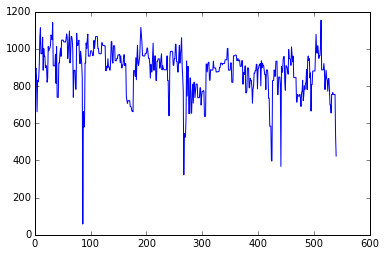

In [88]:
plt.plot(sck_co[1:])

#### FS columns

In [89]:
def fs_match(var,ind,title,unit,unit2):
    new = np.array(var[:]) # to np array for new indecies
    new = (new*unit)+unit2 # unit conversion
    new2 = []
    new2 = np.append(title,new2) # add title
    for index in ind:
        new2 = np.append(new[index],new2)
    return new2[::-1]

In [90]:
fs_shift = indemic+95 # SHIFT FOR FS DATA

In [91]:
fs_no2 = fs['NO2']
fs_no2 = fs_match(fs_no2,fs_shift,'fs_NO2ppm',1,0) 
fs_co = fs['CO']
fs_co = fs_match(fs_co,fs_shift,'fs_COppm',1,0) 
fs_o3 = fs['O3']
fs_o3 = fs_match(fs_o3,fs_shift,'fs_O3ppm',1,0) 
fs_voc = fs['VOC']
fs_voc = fs_match(fs_voc,fs_shift,'fs_VOCppm',1,0) 
fs_temp = fs['AirTC']
fs_temp = fs_match(fs_temp,fs_shift,'fs_TempF',1.8,32)
fs_rh = fs['RH']
fs_rh = fs_match(fs_rh,fs_shift,'fs_RH%',1,0)
fs_sol = fs['Up_FlxSlrMJ_Tot']
fs_sol = fs_match(fs_sol,fs_shift,'fs_SolarW',100000,0)
fs_ref = fs['Down_TFlxSlrMJ_Tot']
fs_ref = fs_match(fs_ref,fs_shift,'fs_ReflectW',100000,0)
fs_ws = fs['WS_ms_2']
fs_ws = fs_match(fs_ws,fs_shift,'fs_WSmph',2.23694,0)
fs_wd = fs['WindDir']
fs_wd = fs_match(fs_wd,fs_shift,'fs_WDdeg',1,0) 

#### GPS columns

In [92]:
lat = gps['Latitude']
gps_lat = np.append('gps_lat',lat)
lon = gps['Longitude']
gps_lon = np.append('gps_lon',lon)
dist = gps['DistanceMeters']
gps_dist = np.append('gps_dist',dist)
spd = gps['speed (mph)']
gps_spd = np.append('gps_spd',spd)
alt = gps['AltitudeMeters']
gps_alt = np.append('gps_alt',alt)

### fixedsite location

In [93]:
lat0 = 33.5783411 # need to change this to the actual location
lon0 = -101.8954378
# make arrays of constant lat and long for fixed site
fs_lat = np.array([lat0]*len(gpstime))
fs_lat = np.append('fs_Latitude',fs_lat) # add title
fs_lon = np.array([lon0]*len(gpstime))
fs_lon = np.append('fs_Longitude',fs_lon) # add title

#### writing to files

In [94]:
# write to columns in .csv
rows = zip(gpstime,sckfstime, # time information
           gps_lat,gps_lon,gps_alt,gps_dist,gps_spd, #gps information
           sck_co,sck_no2, # sck variables
           fs_lat,fs_lon,fs_co,fs_no2,fs_o3,fs_voc,fs_temp,fs_rh,fs_sol,fs_ref,fs_ws,fs_wd) # fixed site variables
with open('Oct14_combo.csv', 'wb') as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)